# Data visualization throttled (no latency):
Unthrottled memory power = ~3000

| # | Setting |
| --- | --- |
| Device | macbook pro 14-inch, 2023 | 
| Chip | Apple M2 Pro | 
| Memory | 16 GB | 
| macOS | 15.1.1 | 
| Java | openjdk 21.0.5 | 
| Node | v23.3.0 | 
| Angular | v18.2.x | 

## Throttling

| # | Setting |
| --- | --- |
| CPU | 4x CPU slowdown | 
| download | 1.6 Mbps | 
| upload | 750 Kbps | 
| latency | 0ms | 

## Core Web Vitals Measurements:

**Long task**
- Task that takes more than 50ms

**TTFB (Time to First Byte):**
 - Time from navigation start until the first byte of response is received
 - Calculated using: performance.getEntriesByType('navigation')[0].responseStart
 
**FCP (First Contentful Paint):**
 - Time when the first text, image, or other content appears on the screen.
 - Is the 'endTime' of the first-contentful-paint
 - FCP includes all things that happened before it (like TTFB).
 
**LCP (Largest Contentful Paint):**
 - Time when the largest text or image element is rendered on the screen (so endTime)
 - Is the 'endTime' of the largest-contentful-paint.
 - FCP includes all things that happened before it (like TTFB).
 
**TTI (Time to Interactive):**
 - Time when the page becomes 'reliably' interactive
 - It is measured as the endtime of the last 'long task' after the FCP starttime
 - If no tasks are found, it is the end-time of the FCP.
 
**TBT (Total Blocking Time):**
 - Sum of all "blocking time" for long tasks between start of FCP and TTI
 - Blocking time = accumulation of (task duration - 50ms) of each long task.
 - TBT contains a 'quiet window' of 5s, if this window is expired, the test will end.
 - The quiet window starts after the FCP. 


In [8]:
import pandas as pd;
import numpy as np;
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: '%.2f' % x)

csr_dataset = pd.read_csv('../data/results-csr-throttled-no-latency.csv', sep=',')
ssr_dataset = pd.read_csv('../data/results-ssr-throttled-no-latency.csv', sep=',')

datasets =	{
  "ssr": ssr_dataset,
  "csr": csr_dataset,
}

csr_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   site         50 non-null     object 
 1   date         50 non-null     object 
 2   time         50 non-null     object 
 3   navTime      50 non-null     int64  
 4   totalTime    50 non-null     int64  
 5   lcp          50 non-null     float64
 6   fcp          50 non-null     float64
 7   ttfb         50 non-null     float64
 8   tbt          50 non-null     int64  
 9   tti          50 non-null     float64
 10  longTasks    50 non-null     int64  
 11  longestTask  50 non-null     int64  
 12  error        0 non-null      float64
dtypes: float64(5), int64(5), object(3)
memory usage: 5.2+ KB


In [9]:
features = ['navTime','totalTime','lcp', 'fcp', 'ttfb', 'tbt', 'longTasks', 'longestTask']
headers = ["feature","dataset","Tests", "min", "1st Qrt.", "mean", "median", "3rd Qrt.", "max", "std dev."] 
report = []

datasets["ssr"].size

for f in features:
  for d in datasets:
    report.append([
        f,
        d,
        datasets[d][f].size,
        datasets[d][f].min(),
        datasets[d][f].quantile(0.25),
        datasets[d][f].mean(),
        datasets[d][f].median(),
        datasets[d][f].quantile(0.75),
        datasets[d][f].max(),
        datasets[d][f].std(),
    ])

pd.DataFrame(report, columns=headers)

,feature,dataset,Tests,min,1st Qrt.,mean,median,3rd Qrt.,max,std dev.
0,navTime,ssr,50,3468.00,3476.00,3479.06,3479.00,3484.00,3487.00,5.48
1,navTime,csr,50,10502.00,10521.00,10527.62,10528.00,10530.00,10644.00,19.15
2,totalTime,ssr,50,8479.00,8487.00,8489.78,8489.50,8494.00,8498.00,5.49
3,totalTime,csr,50,15514.00,15532.00,15538.62,15538.00,15541.00,15665.00,20.29
4,lcp,ssr,50,2956.30,2964.05,2969.07,2970.90,2972.25,2980.20,6.71
5,lcp,csr,50,9993.90,10009.33,10022.69,10022.50,10031.38,10138.60,21.80
6,fcp,ssr,50,492.60,502.17,507.36,505.25,511.25,531.50,8.67
7,fcp,csr,50,302.30,305.32,315.55,312.85,319.62,403.10,15.57
8,ttfb,ssr,50,14.90,15.63,19.83,22.30,22.90,30.40,4.18
9,ttfb,csr,50,7.00,8.20,9.17,8.60,8.90,30.70,3.30


<module 'matplotlib.pyplot' from '/Users/auke/Library/Python/3.9/lib/python/site-packages/matplotlib/pyplot.py'>

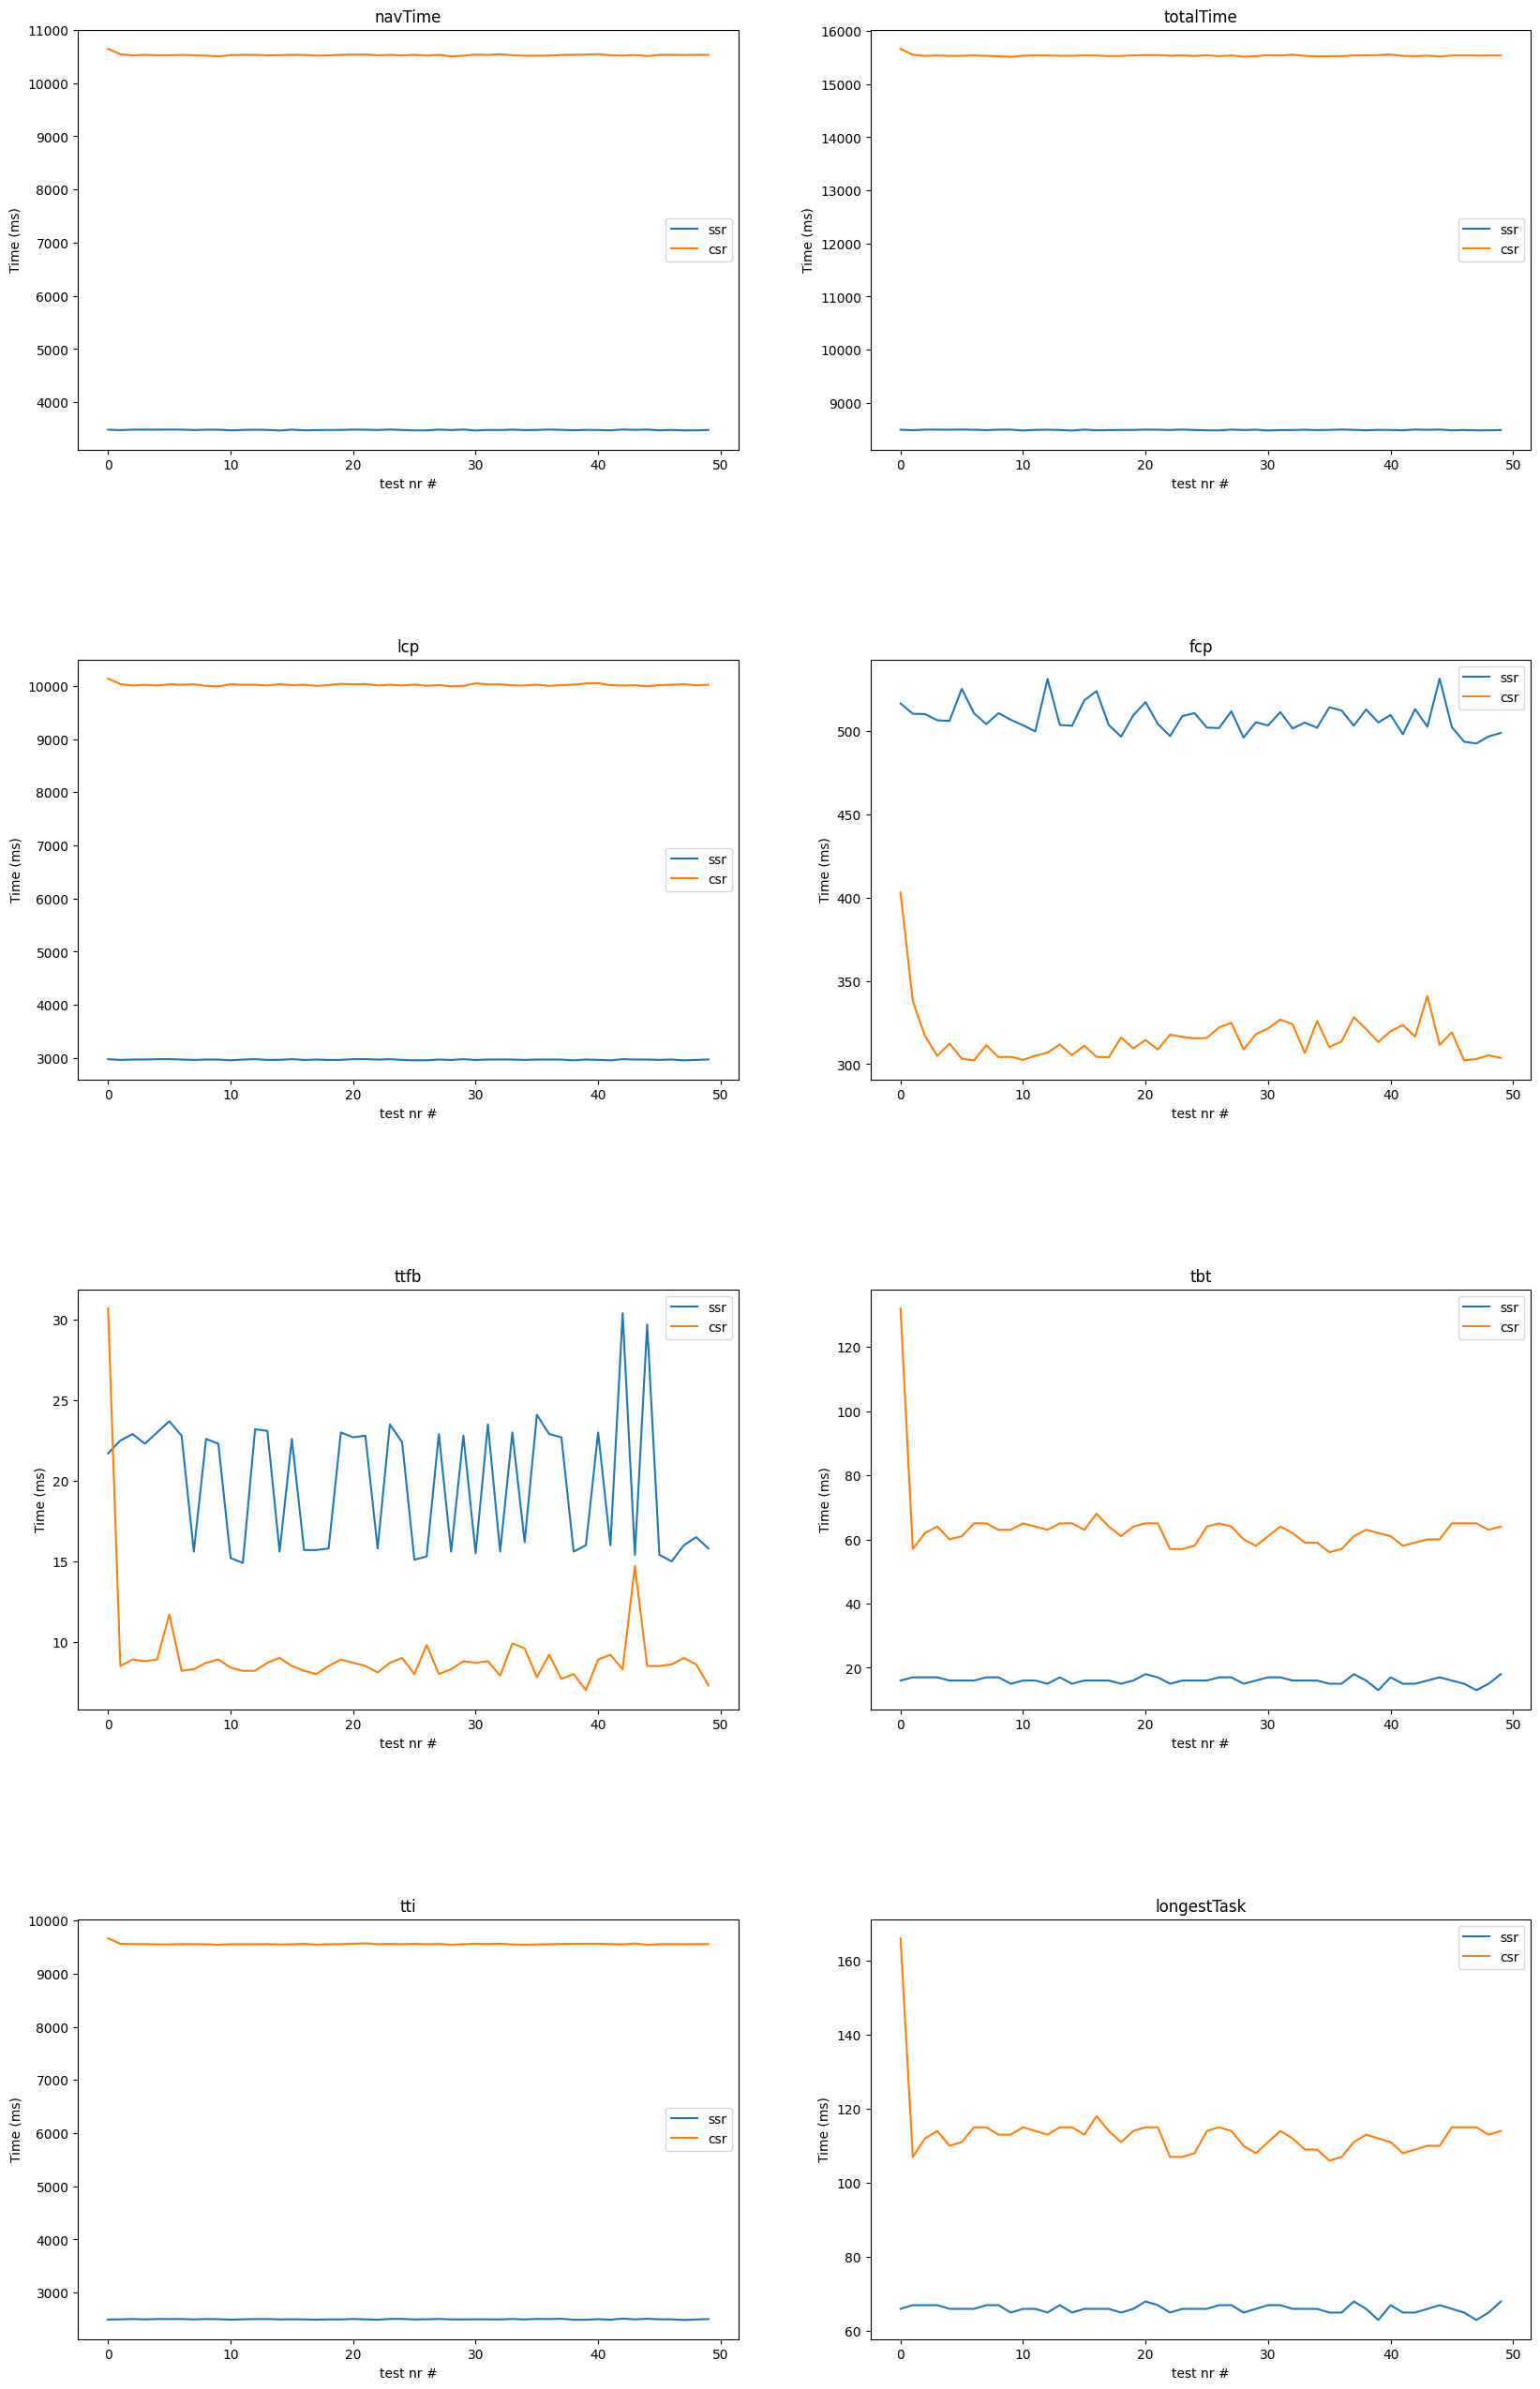

In [10]:
def ceildiv(a, b): return -(a // -b)

def plot_line_graph(feature, loc):
    for d in datasets:
        loc.plot(datasets[d][feature], label=d)
    
    loc.set_title(feature)
    loc.set_ylabel('Time (ms)') 
    loc.set_xlabel('test nr #') 

    loc.legend()
    


def graphs(plot_func, features,cols=2, height=8):
    rows = ceildiv(len(features), cols)
    _, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, height*rows))
    plt.subplots_adjust(hspace=0.5)
    for i, feature in enumerate(features):
        loc = axes[i // cols, i % cols] if rows > 1 and cols > 1 else axes[i % cols]
        plot_func(feature, loc)
    return plt

graphs(plot_line_graph, ['navTime','totalTime','lcp', 'fcp', 'ttfb', 'tbt', 'tti', 'longestTask'])

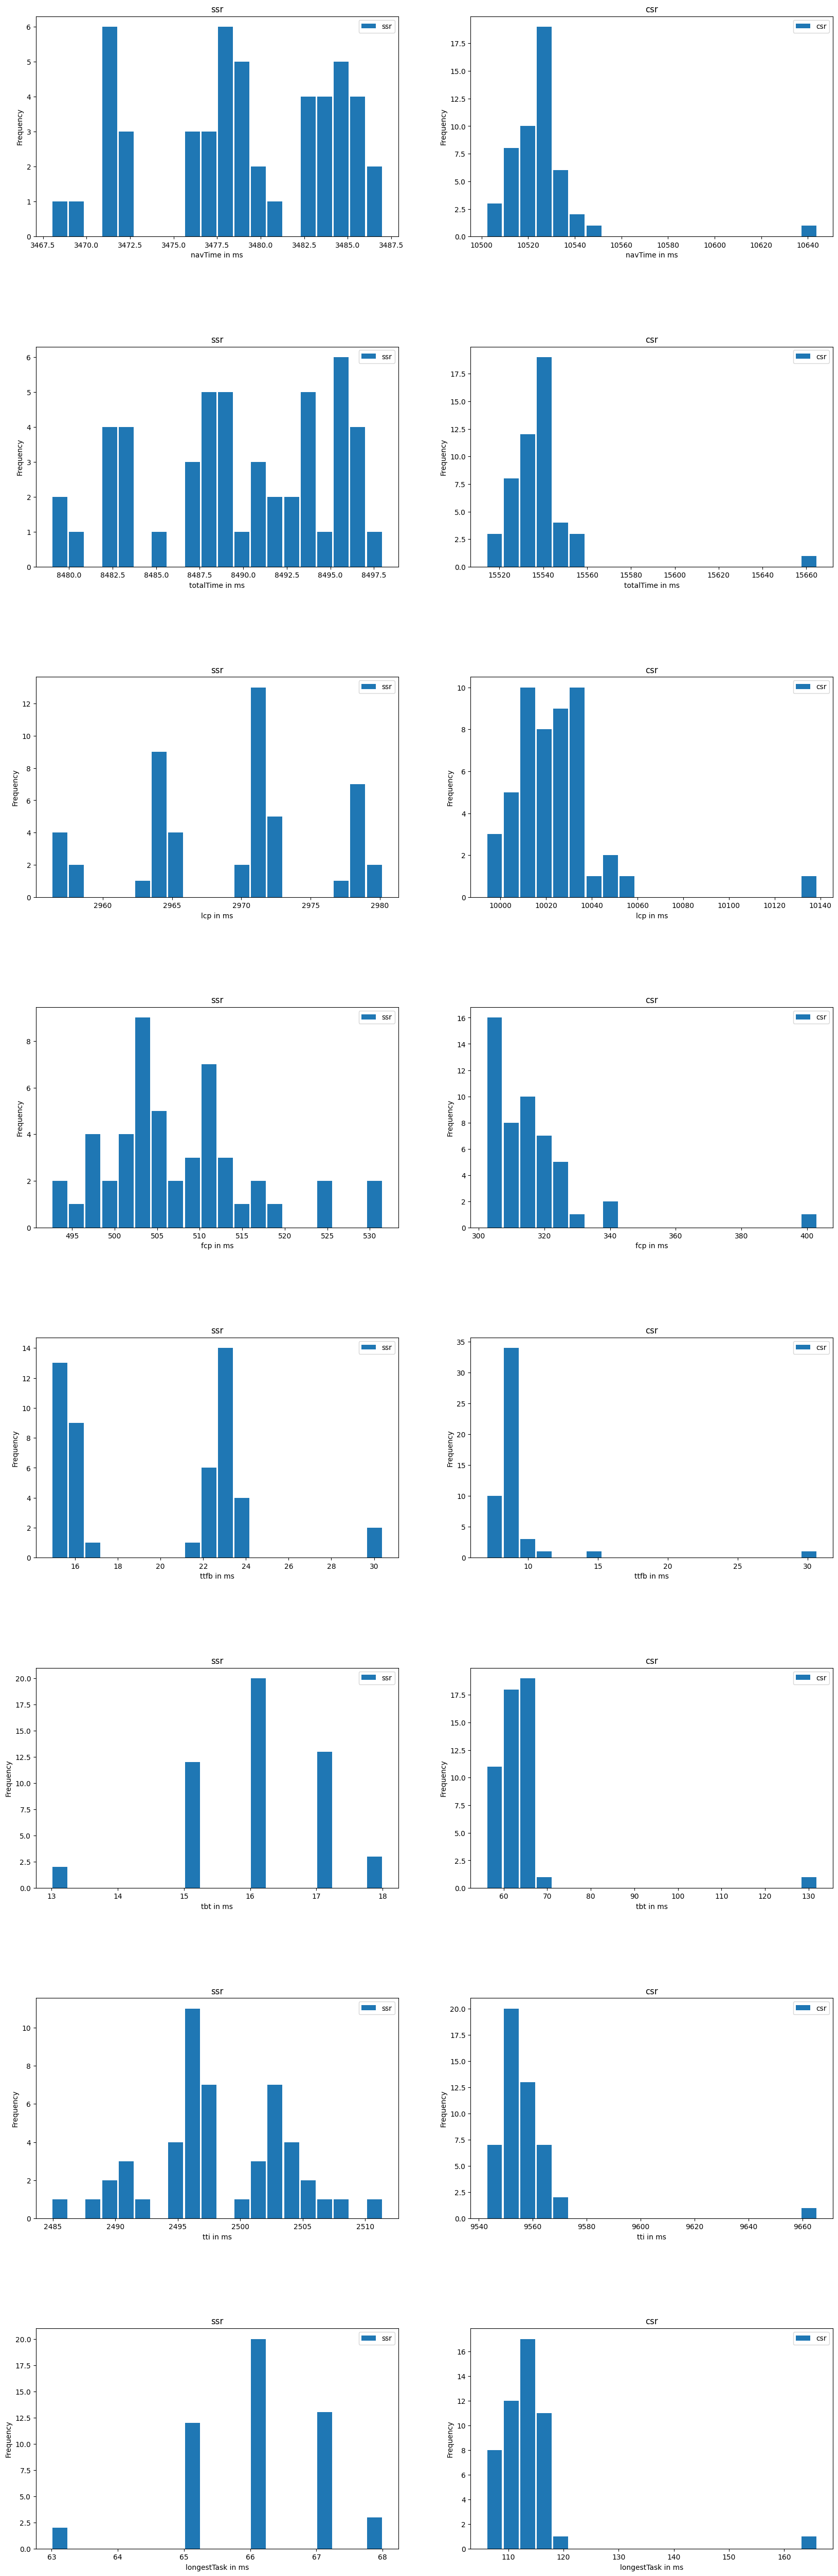

In [11]:
def plot_histogram(d, f, loc):
    data = datasets[d][f].sort_values()
    data.plot(kind='hist', ax=loc, title=f, rwidth=0.9, bins=20)
    loc.set_xlabel(f + ' in ms')
    loc.set_ylabel('Frequency')
    loc.set_title(d)
    loc.legend([d])

def graphs(plot_func, features,height=8):
    rows = len(features)
    cols = len(datasets)

    _, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, height*rows))
    plt.subplots_adjust(hspace=0.5)
    for y, f in enumerate(features):
        for x, d in enumerate(datasets):
            plot_func(d, f, axes[y, x])
    return plt

plt = graphs(plot_histogram, ['navTime','totalTime','lcp', 'fcp', 'ttfb', 'tbt', 'tti', 'longestTask'])
plt.show()

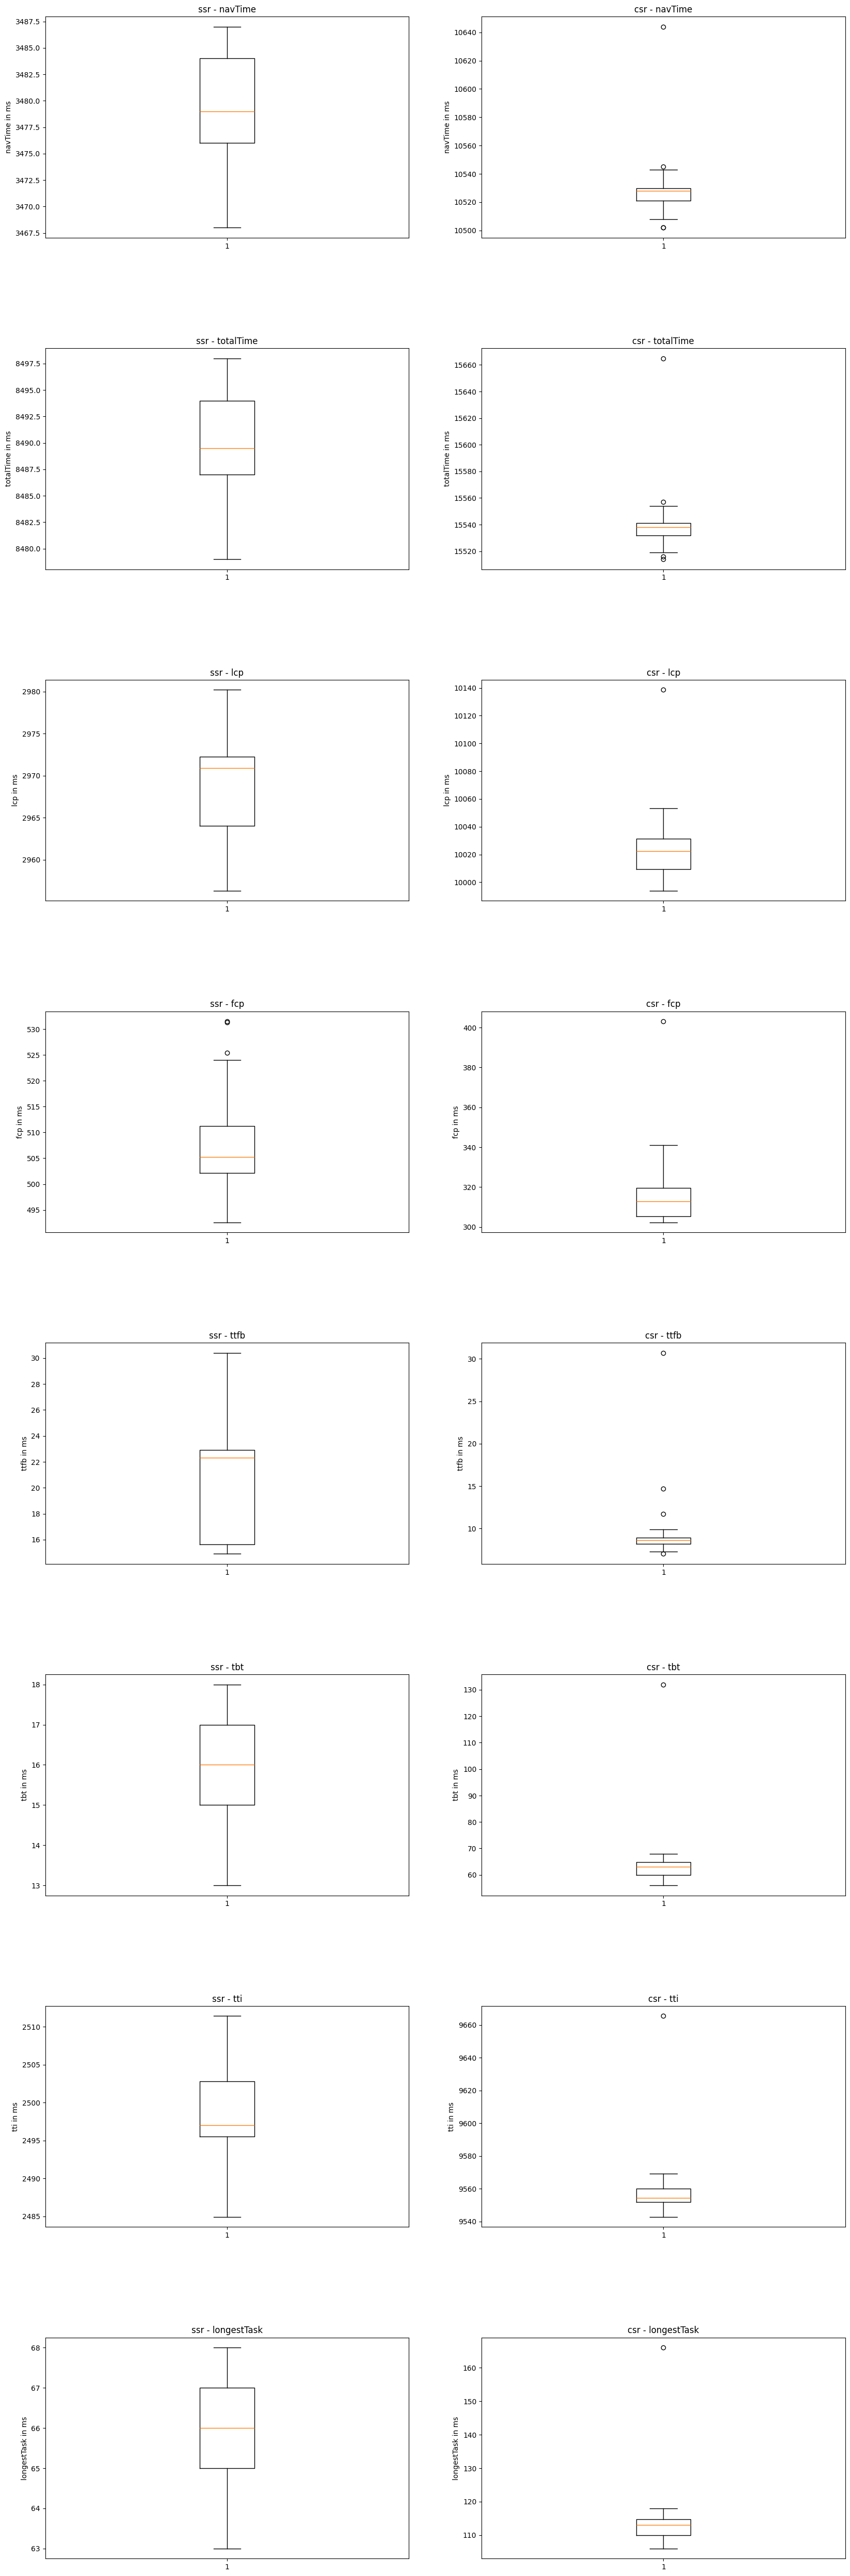

In [12]:
def plot_box_plot(d, f, loc):
    data = datasets[d][f]
    loc.boxplot(data, vert=True)
    loc.set_title(f'{d} - {f}')
    loc.set_ylabel(f + ' in ms')

def graphs(plot_func, features, height=8):
    rows = len(features)
    cols = len(datasets)

    _, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, height*rows))
    plt.subplots_adjust(hspace=0.5)
    for y, f in enumerate(features):
        for x, d in enumerate(datasets):
            plot_func(d, f, axes[y, x])
    return plt

plt = graphs(plot_box_plot, ['navTime', 'totalTime', 'lcp', 'fcp', 'ttfb', 'tbt', 'tti', 'longestTask'])
plt.show()

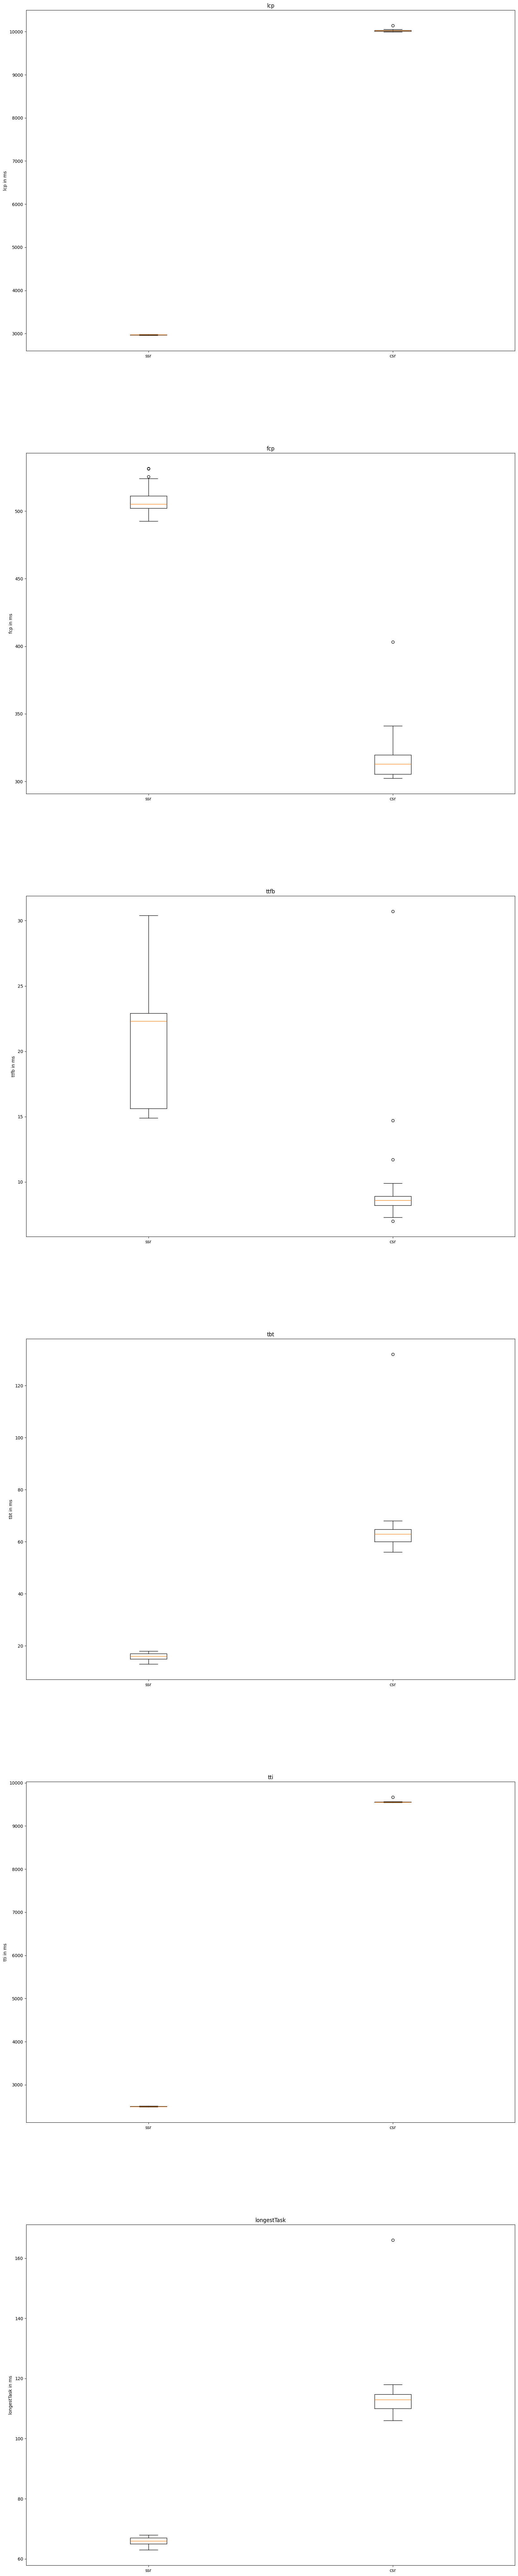

In [13]:
def plot_box_plot(f, loc):
    data = [datasets[d][f] for d in datasets]
    loc.boxplot(data, tick_labels=datasets.keys())
    loc.set_title(f)
    loc.set_ylabel(f + ' in ms')

def graphs(plot_func, features, height=15):
    rows = len(features)
    cols = 1  # One column for box plots

    _, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, height*rows))
    plt.subplots_adjust(hspace=0.3, top=0.95, bottom=0.05)  # Adjust spacing
    for y, f in enumerate(features):
        plot_func(f, axes[y])
    return plt

plt = graphs(plot_box_plot, ['lcp', 'fcp', 'ttfb', 'tbt', 'tti', 'longestTask'])
plt.show()

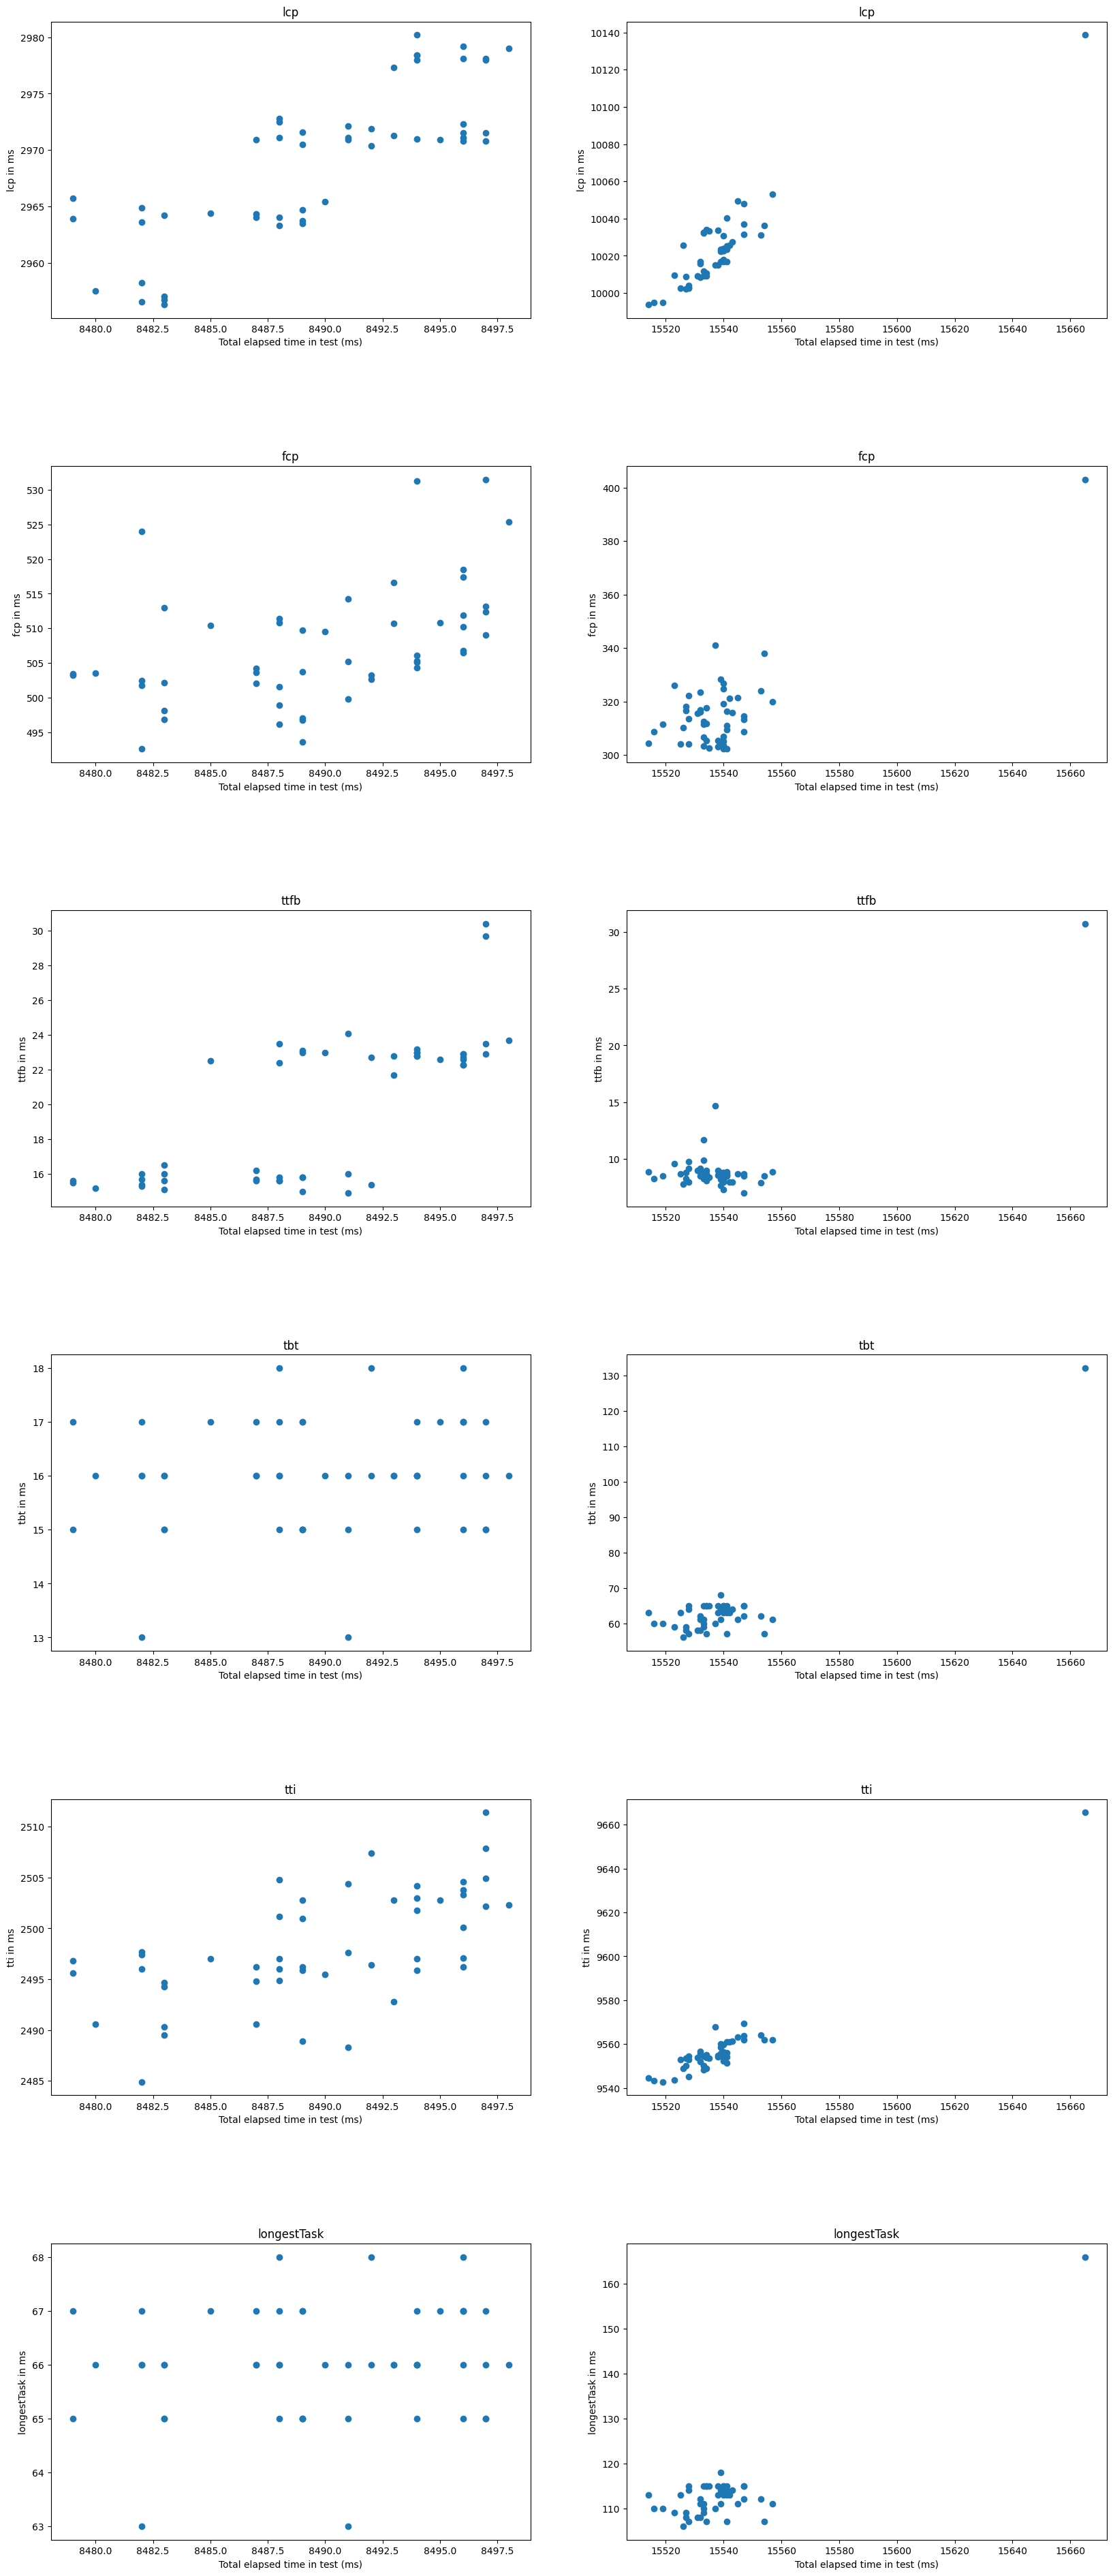

In [14]:
def plot_scatter_plot(d, f, loc):
    loc.scatter(datasets[d]['totalTime'], datasets[d][f], label=d)
    loc.set_title(f)
    loc.set_xlabel('Total elapsed time in test (ms)')
    loc.set_ylabel(f + ' in ms')

def graphs(plot_func, features, height=8):
    rows = len(features)
    cols = len(datasets)

    _, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, height*rows))
    plt.subplots_adjust(hspace=0.5)
    for y, f in enumerate(features):
        for x, d in enumerate(datasets):
            plot_func(d, f, axes[y, x])
    return plt

plt = graphs(plot_scatter_plot, ['lcp', 'fcp', 'ttfb', 'tbt', 'tti', 'longestTask'])
plt.show()
